### Basic Environment Set Up and Check

In [1]:
with open(".env", "w") as f:
    f.write("real_toekn/n")  # Replace with your real token
print(".env file created successfully!")

.env file created successfully!


In [5]:
# Check if .env Exists
import os
print(".env file exists:", os.path.exists(".env"))

.env file exists: True


In [6]:
print(os.listdir())  # Lists all files in the current directory

['.DS_Store', 'github-trend-env', 'LICENSE', 'dashboard.py', '.gitignore', '.env', '.ipynb_checkpoints', '.git', 'github_trend_analysis.ipynb']


In [7]:
import os 
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv(dotenv_path="/Users/sydneyci11/Library/CloudStorage/OneDrive-CornellUniversity/Side_Project/github-trend-analysis/.env")

# Retrieve the GitHub Token
github_token = os.getenv("GITHUB_TOKEN")

# Test if the token is loaded
if github_token:
    print("GitHub Token loaded successfully!")
else:
    print("Failed to load GitHub Token. Check your .env file.")

GitHub Token loaded successfully!


In [8]:
import requests

headers = {
    "Authorization": f"token {os.environ['GITHUB_TOKEN']}"
}

# Test GitHub API
url = "https://api.github.com/user"
response = requests.get(url, headers=headers)

# Check if the API implemented successfully
if response.status_code == 200:
    print("GitHub API Token Set Successfully！")
    print(response.json())  # Show the user indfo
else:
    print(f"Error: {response.status_code}, {response.text}")

GitHub API Token Set Successfully！
{'login': 'sydneyci11', 'id': 114530581, 'node_id': 'U_kgDOBtOZFQ', 'avatar_url': 'https://avatars.githubusercontent.com/u/114530581?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/sydneyci11', 'html_url': 'https://github.com/sydneyci11', 'followers_url': 'https://api.github.com/users/sydneyci11/followers', 'following_url': 'https://api.github.com/users/sydneyci11/following{/other_user}', 'gists_url': 'https://api.github.com/users/sydneyci11/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/sydneyci11/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/sydneyci11/subscriptions', 'organizations_url': 'https://api.github.com/users/sydneyci11/orgs', 'repos_url': 'https://api.github.com/users/sydneyci11/repos', 'events_url': 'https://api.github.com/users/sydneyci11/events{/privacy}', 'received_events_url': 'https://api.github.com/users/sydneyci11/received_events', 'type': 'User', 'user_view_type': 'privat

### Drop and Recreate the Table (Force Schema Update)

In [24]:
import duckdb
import requests
import pandas as pd
from dotenv import load_dotenv
import os

# Define the new database path (local storage)
local_db_path = "/Users/sydneyci11/Documents/github-trend-analysis/github_trends.duckdb"

# Ensure the directory exists
os.makedirs(os.path.dirname(local_db_path), exist_ok=True)

# Force recreate the table if schema is outdated
def reset_database():
    conn = duckdb.connect(local_db_path)
    cursor = conn.cursor()
    
    # Drop the table if it exists
    cursor.execute("DROP TABLE IF EXISTS github_trends;")
    
    # Create the table with correct schema
    cursor.execute("""
        CREATE TABLE github_trends (
            name TEXT,
            full_name TEXT PRIMARY KEY,
            description TEXT,
            stars INTEGER,
            forks INTEGER,
            language TEXT,
            watchers INTEGER,
            commits INTEGER,
            issues INTEGER,
            created_at TEXT,
            updated_at TEXT,
            url TEXT
        )
    """)

    conn.commit()
    conn.close()
    print("Database table reset and recreated.")

# Call this function ONCE before inserting data
# reset_database()

### Import Libraries & Load API Token

In [12]:
import requests
import duckdb
import pandas as pd
import time
from dotenv import load_dotenv
import os

# Read GitHub Token
load_dotenv()
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
headers = {"Authorization": f"token {GITHUB_TOKEN}"}

print("Environment loaded successfully!")

Environment loaded successfully!


### Enhance API Handling

In [13]:
# Check API rate limit 
def check_rate_limit():
    url = "https://api.github.com/rate_limit"
    response = requests.get(url, headers=headers)
    data = response.json()
    
    remaining = data["rate"]["remaining"]
    reset_time = data["rate"]["reset"]
    
    print(f"🕒 API Requests Remaining: {remaining}")
    
    # if the remaining time is 0, set the time to wait 
    if remaining == 0:
        wait_time = reset_time - time.time()
        print(f"⏳ API rate limit reached. Waiting {wait_time:.2f} seconds...")
        time.sleep(wait_time + 1)

# test function 
# check_rate_limit()

In [14]:
# Automatic retry the failed request
def fetch_github_data(url, retries=3, wait_time=5):
    """
    When getting data from GitHub API, retry actumatically when error 
    - `retries`: the maximum times of retry 
    - `wait_time`: the iterval time of waiting for retry
    """
    for attempt in range(retries):
        check_rate_limit()
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200:
            return response.json()
        
        print(f"API request failed (Attempt {attempt+1}/{retries}) - Status Code: {response.status_code}")
        
        # if it is API rate limit error (403), then wait for 60 seconds 
        if response.status_code == 403:
            print("Rate limit exceeded. Waiting 60 seconds before retrying...")
            time.sleep(60)
        elif response.status_code == 409:
            print("API Conflict (409) - Skipping this request.")
            return None
        else:
            time.sleep(wait_time)  # Other error, wait for several seconds and retry
    
    print("All retry attempts failed. Returning None.")
    return None  # retries all failed, reutrn None All

# Test the function 
# url = "https://api.github.com/search/repositories?q=machine+learning&sort=stars&order=desc"
# data = fetch_github_data(url)

# if data:
#     print(f"Successfully fetched {len(data['items'])} repositories!")
# else:
#     print("API request completely failed. No data retrieved.")

In [15]:
# Only get the most updated database, if this is most updated version, skip API request 
def should_fetch_repo(repo_name, last_updated):
    """check if the database needs to be updated, if it is most updated, not renew"""
    conn = duckdb.connect(local_db_path)
    cursor = conn.cursor()
    
    cursor.execute("SELECT updated_at FROM github_trends WHERE full_name = ?", (repo_name,))
    result = cursor.fetchall()  
    
    conn.close()
    
    # if the database do not have this data, then fetch the new data
    if not result:
        return True
    
    # if the updated_at in the database is the same as API, not need to update
    db_updated_at = result[0]
    return db_updated_at != last_updated

In [16]:
# Enhance API paging support
def fetch_all_pages(query, max_pages=3):
    """
    Traverse multiple pages of the GitHub API to get more data.
    - `max_pages`: Maximum number of requested pages
    """
    all_repos = []
    check_rate_limit()  # check the API rate limit for the first time
    
    for page in range(1, max_pages + 1):
        check_rate_limit()
        url = f"https://api.github.com/search/repositories?q={query}&sort=stars&order=desc&per_page=100&page={page}"

        # recude the possibility of API conflicts
        time.sleep(2) 
        
        data = fetch_github_data(url)

        if data is None:
            print(f"API return None，skip the qurey：{url}")
            break  # stop requiring 
        
        if data and "items" in data:
            for repo in data["items"]:
                if should_fetch_repo(repo["full_name"], repo["updated_at"]):
                    all_repos.append(repo)
        else:
            break  # No more data, then stop
            print(f"GitHub return empty result，stop asking, there might be no matching repo")
        
        # only sleep when nearly exceed the API rate limit , avoid spedning extra time 
        if len(all_repos) % 500 == 0:
            print("Taking a short break to avoid hitting the rate limit...")
            time.sleep(10)  
    
    return all_repos

# Test: get three pages 
# all_repos = fetch_all_pages("machine learning", max_pages=3)
# print(f"✅ Retrieved {len(all_repos)} repositories across multiple pages.")

In [17]:
# Final Test for API Handling 
query = "machine learning"
local_db_path = "/Users/sydneyci11/Documents/github-trend-analysis/github_trends.duckdb"
all_repos = fetch_all_pages(query, max_pages=3)
print(f"Retrieved {len(all_repos)} repositories across multiple pages.")

🕒 API Requests Remaining: 4997
🕒 API Requests Remaining: 4997
🕒 API Requests Remaining: 4997
🕒 API Requests Remaining: 4997
🕒 API Requests Remaining: 4997
🕒 API Requests Remaining: 4997
🕒 API Requests Remaining: 4997
Retrieved 300 repositories across multiple pages.


### Fetch Repository Data from GitHub API and Store to Database

In [25]:
# Define the new database path (local storage)
local_db_path = "/Users/sydneyci11/Documents/github-trend-analysis/github_trends.duckdb"

# Ensure the directory exists
os.makedirs(os.path.dirname(local_db_path), exist_ok=True)

In [1]:
# Create & Connect to Duckdb Database
def setup_database():
    conn = duckdb.connect(local_db_path)
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS github_trends (
            name TEXT,
            full_name TEXT PRIMARY KEY,
            description TEXT,
            stars INTEGER,
            forks INTEGER,
            language TEXT,
            watchers INTEGER,
            commits INTEGER,
            issues INTEGER,
            created_at TEXT,
            updated_at TEXT,
            url TEXT
        )
    """)
    conn.commit()
    conn.close()  # Close connection after creating table
    print(f"Database successfully created at: {local_db_path}")

In [30]:
# Function to insert data into the local database
def save_to_db(repo_data):    
    # Reopen database connection inside function
    conn = duckdb.connect(local_db_path)
    cursor = conn.cursor()

    # Check if repo already exists
    cursor.execute("SELECT updated_at FROM github_trends WHERE full_name = ?", (repo_data[1],))
    result = cursor.fetchone()

    if result:
        db_updated_at = str(result[0])
        if db_updated_at != repo_data[10]: # only update the new changed data 
            # If repo exists, update the record
            sql_query = """UPDATE github_trends 
                           SET description=?, stars=?, forks=?, language=?, watchers=?, commits=?, issues=?, updated_at=?, url=? 
                           WHERE full_name=?"""

            # the UPDATE query doesn't need name, full_name, or created_at, so we slice them out.
            cursor.execute(sql_query, repo_data[2:10] + (repo_data[10], repo_data[1]))

            if cursor.rowcount > 0:
                # print(f"[UPDATE] {repo_data[1]} is updated")
                conn.commit()
                conn.close()
                return "update"  
            else:
                # print(f"[WARNING] {repo_data[1]} updated failed, please check the data!")
                conn.close()
                return None
    
    else:
        # Insert new record
        sql_query = """INSERT INTO github_trends 
                       (name, full_name, description, stars, forks, language, watchers, commits, issues, created_at, updated_at, url) 
                       VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"""
        cursor.execute(sql_query, repo_data)
        # print(f"[INSERT] {repo_data[1]} insert new data")
        return "insert"
        
    conn.commit()
    conn.close()  # Close connection after inserting

In [31]:
# Ensure database is created
setup_database()

# Define search query & fetch data
# search_query = "deep learning"
search_queries = [
    "deep learning",
    "machine learning",
    "ML",
    "AI robotics",
    "natural language processing",
    "NLP",
    "computer vision",
    "generative AI",
    "transformers",
    "open source llm",
    "autonomous vehicle",
    "AI infrastructure",
    "AI"
]

max_pages = 3

# all_repos = fetch_all_pages(search_query, max_pages=3)

for search_query in search_queries:
    print(f"\nSearching for: {search_query}")
    all_repos = fetch_all_pages(search_query, max_pages=max_pages)
    
    if all_repos:
        print(f"Successfully fetched {len(all_repos)} repositories!")

        for repo in all_repos:
            issue_count = repo.get("open_issues_count", 0)

            # Fetch commit count using a separate API request (optional)
            commits_url = f"https://api.github.com/repos/{repo['full_name']}/commits"
            commits_resp = fetch_github_data(commits_url)

            # Handle case when no commits are returned
            commit_count = len(commits_resp) if isinstance(commits_resp, list) else 0

            repo_data = (
                repo["name"] if repo["name"] is not None else "Unknown",
                repo["full_name"] if repo["full_name"] is not None else "Unknown",
                repo["description"] if repo["description"] is not None else "No description available",
                repo["stargazers_count"] if repo["stargazers_count"] is not None else 0,
                repo["forks_count"] if repo["forks_count"] is not None else 0,
                repo["language"] if repo["language"] is not None else "Not specified",
                repo["watchers_count"] if repo["watchers_count"] is not None else 0,
                commit_count if commit_count is not None else 0,
                issue_count if issue_count is not None else 0,
                repo["created_at"] if repo["created_at"] is not None else "Unknown",
                repo["updated_at"] if repo["updated_at"] is not None else "Unknown",
                repo["html_url"] if repo["html_url"] is not None else "No URL available"
            )

            save_to_db(repo_data)

        print(f"Data successfully saved to: {local_db_path}")

else:
    print("Failed to fetch any data.")


Searching for: deep learning
🕒 API Requests Remaining: 4996
🕒 API Requests Remaining: 4996
🕒 API Requests Remaining: 4996
🕒 API Requests Remaining: 4996
🕒 API Requests Remaining: 4996
🕒 API Requests Remaining: 4996
🕒 API Requests Remaining: 4996
Successfully fetched 300 repositories!
🕒 API Requests Remaining: 4996
🕒 API Requests Remaining: 4995
🕒 API Requests Remaining: 4994
🕒 API Requests Remaining: 4993
🕒 API Requests Remaining: 4992
🕒 API Requests Remaining: 4991
🕒 API Requests Remaining: 4990
🕒 API Requests Remaining: 4989
🕒 API Requests Remaining: 4988
🕒 API Requests Remaining: 4987
🕒 API Requests Remaining: 4986
🕒 API Requests Remaining: 4985
🕒 API Requests Remaining: 4984
🕒 API Requests Remaining: 4983
🕒 API Requests Remaining: 4982
🕒 API Requests Remaining: 4981
🕒 API Requests Remaining: 4980
🕒 API Requests Remaining: 4979
🕒 API Requests Remaining: 4978
🕒 API Requests Remaining: 4977
🕒 API Requests Remaining: 4976
🕒 API Requests Remaining: 4975
🕒 API Requests Remaining: 4974
🕒

### Test API Efficiency 

In [32]:
import time

# 追蹤 API 調用次數
api_call_count = 0
total_response_time = 0

def test_api_efficiency(query, max_pages=3):
    """
    測試 API 請求效率，計算 API 調用次數與平均響應時間
    """
    global api_call_count, total_response_time
    
    all_repos = []
    for page in range(1, max_pages + 1):
        url = f"https://api.github.com/search/repositories?q={query}&sort=stars&order=desc&per_page=100&page={page}"
        
        start_time = time.time()  # 記錄請求開始時間
        data = fetch_github_data(url)  # 調用 API
        end_time = time.time()  # 記錄請求結束時間

        if data and "items" in data:
            all_repos.extend(data["items"])
            api_call_count += 1  # 增加 API 調用次數
            total_response_time += (end_time - start_time)  # 累計 API 響應時間
        else:
            break  # 若 API 無回應則停止
        
        time.sleep(1)  # 避免超過速率限制

    # 計算平均響應時間
    avg_response_time = total_response_time / api_call_count if api_call_count > 0 else 0

    print(f"API 測試完成: 總調用次數 = {api_call_count}, 平均響應時間 = {avg_response_time:.2f} 秒")
    return all_repos

In [62]:
# test_repos = test_api_efficiency("deep learning", max_pages=3)

### Test the API and data update Efficiency 

In [33]:
def test_api_and_db_efficiency(query, max_pages=3):
    """
    測試 API 及資料庫更新效率
    """
    global api_call_count, total_response_time, insert_count, update_count
    api_call_count = 0
    total_response_time = 0
    insert_count = 0
    update_count = 0
    
    all_repos = []
    for page in range(1, max_pages + 1):
        url = f"https://api.github.com/search/repositories?q={query}&sort=stars&order=desc&per_page=100&page={page}"
        
        start_time = time.time()
        data = fetch_github_data(url)
        end_time = time.time()

        if data and "items" in data:
            all_repos.extend(data["items"])
            api_call_count += 1
            total_response_time += (end_time - start_time)
        else:
            break
        
        time.sleep(1)

    avg_response_time = total_response_time / api_call_count if api_call_count > 0 else 0

    # 開始測試資料庫插入與更新效率
    for repo in all_repos:
        issue_count = repo.get("open_issues_count", 0)
        commits_url = f"https://api.github.com/repos/{repo['full_name']}/commits"
        commits_resp = fetch_github_data(commits_url)
        commit_count = len(commits_resp) if isinstance(commits_resp, list) else 0

        repo_data = (
            repo["name"] or "Unknown",
            repo["full_name"] or "Unknown",
            repo["description"] or "No description available",
            repo["stargazers_count"] or 0,
            repo["forks_count"] or 0,
            repo["language"] or "Not specified",
            repo["watchers_count"] or 0,
            commit_count,
            issue_count,
            repo["created_at"] or "Unknown",
            repo["updated_at"] or "Unknown",
            repo["html_url"] or "No URL available"
        )

        # 插入或更新資料庫，並取得回傳值
        operation = save_to_db(repo_data)
        
        if operation == "insert":
            insert_count += 1
        elif operation == "update":
            update_count += 1

    print(f"API 測試完成: 總調用次數 = {api_call_count}, 平均響應時間 = {avg_response_time:.2f} 秒")
    print(f"資料庫更新完成: 插入新數據 = {insert_count}, 更新數據 = {update_count}")

In [61]:
# test_api_and_db_efficiency("AI robotics", max_pages=3)

In [34]:
def debug_should_fetch_repo(repo_name, last_updated):
    conn = sqlite3.connect(local_db_path)
    cursor = conn.cursor()
    
    cursor.execute("SELECT updated_at FROM github_trends WHERE full_name = ?", (repo_name,))
    result = cursor.fetchone()
    
    conn.close()

    if not result:
        print(f"[DEBUG] {repo_name} 不在資料庫中，需要獲取")
        return True  # 沒有數據，應該 fetch
    
    db_updated_at = result[0]
    
    if db_updated_at == last_updated:
        print(f"[SKIP] {repo_name} 資料已是最新，跳過更新")
    else:
        print(f"[UPDATE] {repo_name} 需要更新（DB: {db_updated_at} vs API: {last_updated}）")
    
    return db_updated_at != last_updated

In [60]:
# for repo in fetch_all_pages("AI robotics", max_pages=3):
#     debug_should_fetch_repo(repo["full_name"], repo["updated_at"])

### Inspect Data

In [36]:
import duckdb
import pandas as pd

# Connect to the local database
conn = duckdb.connect("/Users/sydneyci11/Documents/github-trend-analysis/github_trends.duckdb")

# Run query and return as pandas dataframe
df = conn.execute("SELECT * FROM github_trends LIMIT 10;").fetchdf()
conn.close()

df  # Display the first few rows

,name,full_name,description,stars,forks,language,watchers,commits,issues,created_at,updated_at,url
0,keras,keras-team/keras,Deep Learning for humans,63056,19588,Python,63056,30,303,2015-03-28T00:35:42Z,2025-05-31T23:48:32Z,https://github.com/keras-team/keras
1,annotated_deep_learning_paper_implementations,labmlai/annotated_deep_learning_paper_implemen...,🧑‍🏫 60+ Implementations/tutorials of deep lear...,60835,6147,Python,60835,30,37,2020-08-25T02:29:34Z,2020-08-25T02:29:34Z,2025-06-01T01:13:37Z
2,DeepLearning-500-questions,scutan90/DeepLearning-500-questions,深度学习500问，以问答形式对常用的概率知识、线性代数、机器学习、深度学习、计算机视觉等热点...,56108,15962,JavaScript,56108,30,121,2018-06-27T06:36:45Z,2025-05-31T06:50:50Z,https://github.com/scutan90/DeepLearning-500-q...
3,TTS,coqui-ai/TTS,🐸💬 - a deep learning toolkit for Text-to-Speec...,40412,5194,Python,40412,30,16,2020-05-20T15:45:28Z,2025-05-31T21:54:24Z,https://github.com/coqui-ai/TTS
4,Deep-Learning-Papers-Reading-Roadmap,floodsung/Deep-Learning-Papers-Reading-Roadmap,Deep Learning papers reading roadmap for anyon...,39028,7349,Python,39028,30,91,2016-10-14T11:49:48Z,2025-05-31T21:42:21Z,https://github.com/floodsung/Deep-Learning-Pap...
5,DeepSpeed,deepspeedai/DeepSpeed,DeepSpeed is a deep learning optimization libr...,38663,4404,Python,38663,30,1174,2020-01-23T18:35:18Z,2025-05-31T16:44:14Z,https://github.com/deepspeedai/DeepSpeed
6,deeplearningbook-chinese,exacity/deeplearningbook-chinese,Deep Learning Book Chinese Translation,36450,9154,TeX,36450,30,67,2016-12-07T11:46:51Z,2025-05-31T04:39:03Z,https://github.com/exacity/deeplearningbook-ch...
7,caffe,BVLC/caffe,Caffe: a fast open framework for deep learning.,34390,18622,C++,34390,30,1183,2013-09-12T18:39:48Z,2025-05-31T18:59:47Z,https://github.com/BVLC/caffe
8,pytorch-tutorial,yunjey/pytorch-tutorial,PyTorch Tutorial for Deep Learning Researchers,31321,8206,Python,31321,30,89,2017-03-10T07:41:47Z,2025-05-31T22:14:45Z,https://github.com/yunjey/pytorch-tutorial
9,netron,lutzroeder/netron,"Visualizer for neural network, deep learning a...",30357,2910,JavaScript,30357,30,22,2010-12-26T12:53:43Z,2025-05-31T19:53:41Z,https://github.com/lutzroeder/netron


### Identify Where None Values Appear

In [38]:
# Connect to the database
conn = duckdb.connect("/Users/sydneyci11/Documents/github-trend-analysis/github_trends.duckdb")

# Query for NULL values
df = conn.execute("""
        SELECT * FROM github_trends 
        WHERE description = 'No description available' OR language = 'Not specified'
    """).fetchdf()
conn.close()

# Display DataFrame in Jupyter Notebook
if df.empty:
    print("No default/placeholder values found in the database.")
else:
    print("Repositories with placeholder description/language:")
    print(df.head(10).to_string())  # Displays the entire DataFrame in text format

Repositories with placeholder description/language:
                                                                           name                                                                                   full_name                                                                                                                                                                                                                                                                                                                 description  stars  forks       language  watchers  commits  issues            created_at            updated_at                                                                                                            url
0                                                               tuning_playbook                                                             google-research/tuning_playbook                                                                              

In [39]:
# 分析有多少筆資料使用了 placeholder
placeholder_desc_count = (df['description'] == 'No description available').sum()
placeholder_lang_count = (df['language'] == 'Not specified').sum()
total_rows = len(df)

print(f"\n📊 Data Quality Report (Top 10 shown below)")
print(f"Total affected repositories: {total_rows}")
print(f"- With placeholder description: {placeholder_desc_count}")
print(f"- With unspecified language: {placeholder_lang_count}")


📊 Data Quality Report (Top 10 shown below)
Total affected repositories: 472
- With placeholder description: 44
- With unspecified language: 438


### Visualize GitHub Trends (Data Insights)

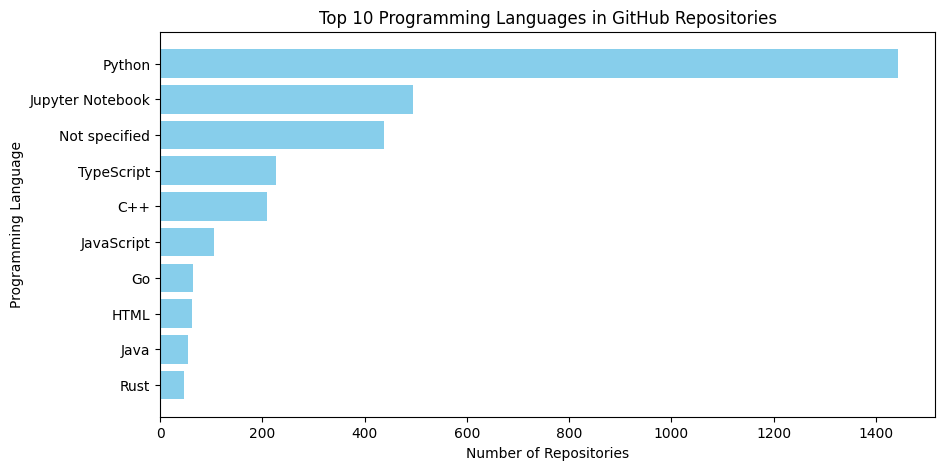

In [41]:
import matplotlib.pyplot as plt

# Connect to the database
conn = duckdb.connect("/Users/sydneyci11/Documents/github-trend-analysis/github_trends.duckdb")

# Query to count repositories per language
df_lang = conn.execute("""
    SELECT language, COUNT(*) as count 
    FROM github_trends 
    GROUP BY language 
    ORDER BY count DESC 
    LIMIT 10;
""").fetchdf()
conn.close()

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.barh(df_lang["language"], df_lang["count"], color="skyblue")
plt.xlabel("Number of Repositories")
plt.ylabel("Programming Language")
plt.title("Top 10 Programming Languages in GitHub Repositories")
plt.gca().invert_yaxis()  # Invert y-axis to show top language first
plt.show()

In [42]:
# Connect to the database
conn = duckdb.connect("/Users/sydneyci11/Documents/github-trend-analysis/github_trends.duckdb")
view_data = conn.execute("""
SELECT COUNT(*) FROM github_trends;
""").fetchdf()
conn.close()

view_data

,count_star()
0,3501
